<h1><center>Predicting Bike Rentals</center></h1>
<h3><center>Predicting the number of Bikes rented per hour in Washington D.C.</center></h3>

Bike rentals have become very popular in many western countries. A simple concept where a person can rent a bicycle per hour or per day, to conveniently travel around without the hassle of traffic, parking, narrow roads etc.<br>
Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day. Hadi Fanaee-T at the University of Porto compiled this data into a CSV file.<br>

The aim of the project is to analyze the bike rentals dataset of the Washington D.C. district and eventually predict the number of bike rentals recieved per hour.
The dataset used can be found on this <a href="http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset">Link</a><br>
The columns are as described below:-

    * instant - A unique sequential ID number for each row
    * dteday - The date of the rentals
    * season - The season in which the rentals occurred
        * 1 - Winter
        * 2 - Spring
        * 3 - Summer
        * 4 - Fall
    * yr - The year the rentals occurred
        * 0 - 2011
        * 1 - 2012
    * mnth - The month the rentals occurred
    * hr - The hour the rentals occurred
    * holiday - Whether or not the day was a holiday
    * weekday - The day of the week (as a number, 0 to 7)
    * workingday - Whether or not the day was a working day
    * weathersit - The weather (as a categorical variable)
        * 1 - Clear, Few clouds, Partly cloudy, Partly cloudy
        * 2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
        * 3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        * 4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    * temp - Normalized temperature, on a 0-1 scale (actual)
    * atemp - Normalized adjusted temperature (What it feels)
    * hum - Normalized humidity, on a 0-1 scale
    * windspeed - Normalzied wind speed, on a 0-1 scale
    * casual - Number of casual riders (people who hadnt previously signed up with the bike sharing program)
    * registered - The number of registered riders (people who had already signed up)
    * cnt - The total number of bike rentals (casual + registered)

The target is the *cnt* column which gives the number of bike rentals recieved, from casual and registered customers.

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus
import plotly.figure_factory as ff

In [2]:
df = pd.read_csv('/home/hp/Downloads/Bikeshare/hour.csv', parse_dates=['dteday'])
df.head(5)

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [3]:
df.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

There are no missing values in the dataset. The dataset looks pretty clean and ready for descriptive and predictive analysis.<br>
For the analysis, every column one by one will be analyzed to discover which columns influence the cnt column and which can be potential predictors for the model. Before starting, the *cnt* column's distribution is shown below to understand the range of data the target can take.

([], <a list of 0 Text yticklabel objects>)

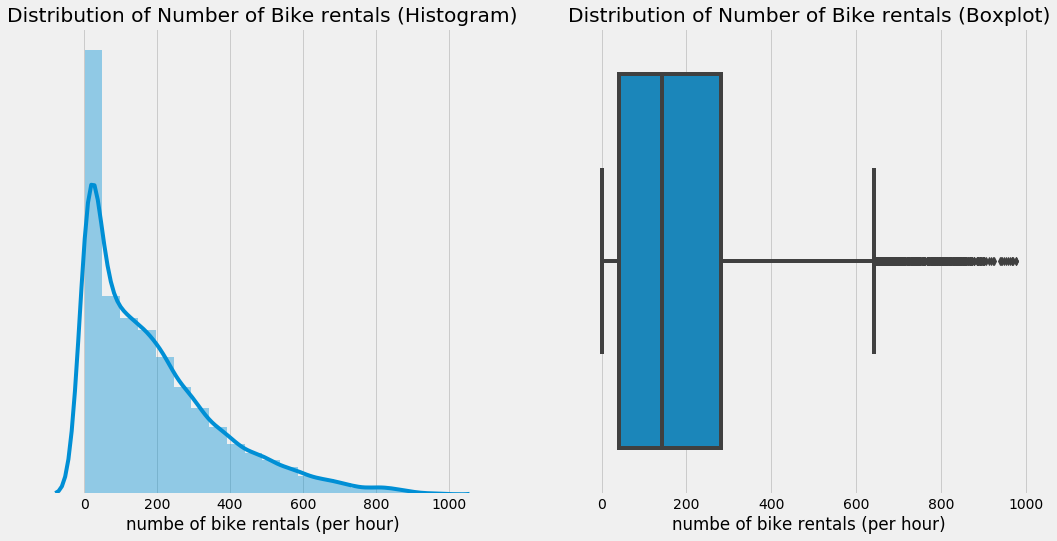

In [4]:
plt.style.use('fivethirtyeight')
plt.subplots(figsize=(16,8))

plt.subplot(1,2,1)
sns.distplot(df.cnt, bins=20)
plt.title('Distribution of Number of Bike rentals (Histogram)')
plt.xlabel('numbe of bike rentals (per hour)')
plt.yticks([])

plt.subplot(1,2,2)
sns.boxplot(df.cnt)
plt.title('Distribution of Number of Bike rentals (Boxplot)')
plt.xlabel('numbe of bike rentals (per hour)')
plt.yticks([])

The distribution draws the following conclusions :-
* The *cnt* is heavily right skewed with most recorded data lying between 0 and 600
* Beyond 600, there are outliers in the data.

Its essential to take a closer look at the outliers for better decision making whether these have to be removed or manipulated.

In [5]:
high_cnt = df[df.cnt > 600]
high_cnt.head(10)

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
3019     3020 2011-05-10       2   0     5  17        0        2           1   
3187     3188 2011-05-17       2   0     5  17        0        2           1   
3379     3380 2011-05-25       2   0     5  17        0        3           1   
3835     3836 2011-06-13       2   0     6  17        0        1           1   
3883     3884 2011-06-15       2   0     6  17        0        3           1   
3884     3885 2011-06-15       2   0     6  18        0        3           1   
4171     4172 2011-06-27       3   0     6  17        0        1           1   
5516     5517 2011-08-22       3   0     8  18        0        1           1   
5536     5537 2011-08-23       3   0     8  14        0        2           1   
5537     5538 2011-08-23       3   0     8  15        0        2           1   

      weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
3019           1  0.64  0.6212  0.33     0.0000      79         532  611  
3187           1  0.62  0.6061  0.65     0.4179      83         521  604  
3379           1  0.74  0.6667  0.51     0.2239      77         524  601  
3835           1  0.70  0.6364  0.39     0.3284      72         529  601  
3883           1  0.74  0.6515  0.28     0.1045      83         555  638  
3884           1  0.72  0.6515  0.32     0.1343      80         527  607  
4171           1  0.74  0.6818  0.55     0.1343      90         514  604  
5516           1  0.72  0.6515  0.28     0.2985      72         537  609  
5536           1  0.72  0.6515  0.30     0.0896     149         502  651  
5537           1  0.72  0.6515  0.34     0.2239     178         423  601

These outliers have high registered customers who have rented bikes as compared to the casual customers. Intuitively, it can be said that on holidays, days with clear weather, office release times, it can be expected to have high bike rentals. For now, assuming that the above theory is correct, the data is left as it is.<br>

The next step is to analyze every column in the dataset and see its relationhip with the number of bike rentals recieved. The *season* column identifies the season as a categorical variable :-

    1 - Winter
    2 - Spring
    3 - Summer
    4 - Fall
    
Logically, the number of bikes rented does depend on the season, Winters would see less bike rentals as compared to Spring and Fall due to the extremeties in the climate. The Summer is not as harsh and hence can have more rentals as compared to Winter.<br>

The metric chosen for the comparision is "percentage of bike rentals". For every category the percentage of bike rentals amassed by that category is calculated, for example comparing the seasons, the percentage of bike rentals every season recieves as compared to the total is the differentiator.

In [6]:
total_rentals = df.cnt.sum()
registered_rentals = df.registered.sum()
casual_rentals = df.casual.sum()

These variables will be utilized through the analysis.

In [7]:
seasons = ['Winter','Spring','Summer','Fall']

grouped = df[['season','casual','registered','cnt']].groupby(by='season',)
season_cnts = grouped.sum().reset_index()
season_cnts['season'] = seasons
season_cnts['cnt_perc'] = season_cnts.cnt / total_rentals * 100
season_cnts['registered_perc'] = season_cnts.registered / total_rentals * 100
season_cnts['casual_perc'] = season_cnts.casual / total_rentals * 100
season_cnts

season  casual  registered      cnt   cnt_perc  registered_perc  \
0  Winter   60622      410726   471348  14.315030        12.473916   
1  Spring  203522      715067   918589  27.897921        21.716876   
2  Summer  226091      835038  1061129  32.226919        25.360444   
3    Fall  129782      711831   841613  25.560129        21.618597   

   casual_perc  
0     1.841115  
1     6.181046  
2     6.866476  
3     3.941532

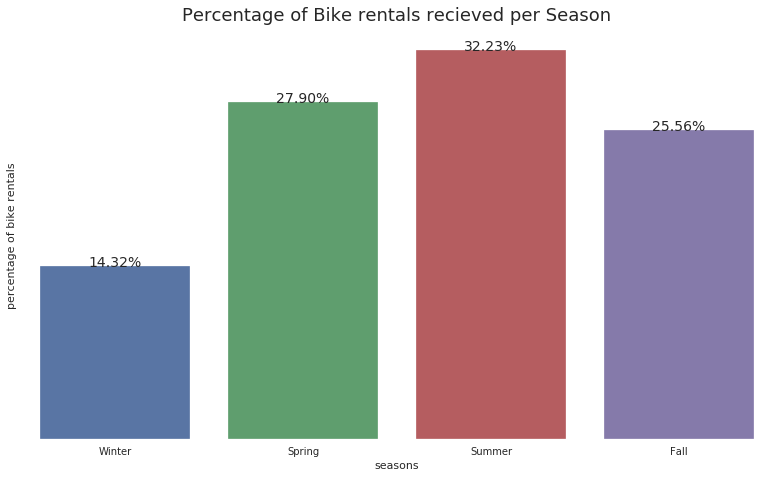

In [8]:
plt.style.use('seaborn')
sns.set_style('white')
plt.figure(figsize=(12,7))
bplt = sns.barplot(x= season_cnts.season, y= season_cnts.cnt_perc)
plt.title('Percentage of Bike rentals recieved per Season', y= 1.01, fontdict={'size':18})
plt.ylabel('percentage of bike rentals')
plt.xlabel('seasons')
plt.yticks([])

for patch in bplt.patches:
    bplt.annotate(
        "{:.2f}%".format(patch.get_height()),
        (patch.get_x() + patch.get_width()/2, patch.get_height()),
        ha='center',
        va='baseline'
    )

As expected, the seasons Spring, Summer recieve the maximum percentage of bike rentals. The Fall season relatively recieves lesser rentals as it nears Winters when the climate gets a little cold and finally Winters sees the least of the lot. The number of bike rentals shows a heavy reliance on the season column. The plot below is a granular representation of the average number of bike rentals per season for casual and registered rentals.

In [9]:
layout = go.Layout(
    title= {
        'text':'<b>Percentage of Bike rentals recieved per Season</b><br>'+
        'Distribution of Bike rentals (percentages) recieved per season for casual and registered customers',
    },
    yaxis= go.layout.YAxis(
        title= 'Seasons'
    ),
    xaxis= go.layout.XAxis(
        title= 'percentage of Bike rentals',
        range=[-8,26],
        showticklabels=False
    ),
    barmode= 'overlay',
    bargap= 0.1
)

data = [
    go.Bar(
        y= season_cnts.season,
        x= season_cnts.registered_perc,
        orientation= 'h',
        name= 'Registered rentals',
        hovertemplate='%{x:.2f}%<extra></extra>',
        marker=dict(color='skyblue')
    ),
    go.Bar(
        y= season_cnts.season,
        x= [-1*x for x in season_cnts.casual_perc],
        orientation= 'h',
        name= 'Casual rentals',
        text= season_cnts.casual_perc,
        hovertemplate='%{text:.2f}%<extra></extra>',
        marker=dict(color='#FC4040')
    )
]

fig = go.Figure(data= data, layout= layout)
fig.show()

The following conclusions can be drawn from the granular information plotted above:-
* As concluded before, the percentage of bike rentals recieved is the highest in the Spring and Summer seasons.
* The percentage of registered rentals (customers) is higher than the percentage of casual rentals (customers).
* The seasons Spring and Summer also see a peak in casual rentals and a major decline in the Winter season.

The column that gives the month, *mnth* is also covered in this since, seasons last over a group of months which do not change. All the seasons have the following month group:- 

* Winter - 12,1,2,3
* Spring - 3,4,5,6
* Summer - 6,7,8,9
* Fall - 9,10,11,12

For this reason, it is suspected that the *mnth* column wil mimic the results obtained here.

In [10]:
months = ['Jan','Feb','Mar','Apr','May',
         'Jun','Jul','Aug','Sept',
         'Oct','Nov','Dec']

grouped = df[['mnth','casual','registered','cnt']].groupby(by= 'mnth')
mnth_cnts = grouped.sum().reset_index()
mnth_cnts.mnth = months
mnth_cnts['cnt_perc'] = mnth_cnts.cnt / total_rentals * 100
mnth_cnts

mnth  casual  registered     cnt   cnt_perc
0    Jan   12042      122891  134933   4.097970
1    Feb   14963      136389  151352   4.596622
2    Mar   44444      184476  228920   6.952393
3    Apr   60802      208292  269094   8.172494
4    May   75285      256401  331686  10.073439
5    Jun   73906      272436  346342  10.518547
6    Jul   78157      266791  344948  10.476211
7    Aug   72039      279155  351194  10.665905
8   Sept   70323      275668  345991  10.507887
9    Oct   59760      262592  322352   9.789961
10   Nov   36603      218228  254831   7.739321
11   Dec   21693      189343  211036   6.409249

In [11]:
# plt.style.use('seaborn')
# sns.set_style('white')
# plt.figure(figsize=(12,7))
# bplt = sns.barplot(x= mnth_cnts.mnth, y= mnth_cnts.cnt)
# plt.title('Average Number of Bike rentals per Month', y= 1.01, fontdict={'size':18})
# plt.ylabel('average number of bike rentals')
# plt.xlabel('month')
# plt.yticks([])

colors = [
    '#009999','#009999','#009999','#009999',
    '#ff9933','#ff9933','#ff9933','#ff9933',
    '#ff9933','#009999','#009999','#009999'
]

layout = go.Layout(
    title= {
        'text': '<b>Percentage of Bike rentals recieved per Month</b>',
        'x':0.5
    },
    yaxis = go.layout.YAxis(
        title= 'percentage of bike rentals',
        showticklabels= False
    ),
    xaxis = go.layout.XAxis(
        title= 'month'
    )
)

data = [
    go.Bar(
        y= mnth_cnts.cnt_perc,
        x= mnth_cnts.mnth,
        hovertemplate='%{y:.2f}%<extra></extra>',
        marker_color=colors
    )
]

fig = go.Figure(data= data, layout= layout)
fig.show()

As suspected earlier, the *mnth* column concludes the same results as the *season* column. The months highlighted - May to September represent the peak in the percentage of bike rentals recieved of the Spring and Summer season. The Fall and Winter season recieve lesser (in that order) percentage of rentals, the months October through April.<br>

The *hr* column gives the time of the day. The dataset has per hour counts for the number of Bikes rented. The *hr* is a discrete variable with values from 0 to 24. For the ease of analysis, these values are grouped together into 4 categories which are intuitively easier to understand.

* Morning - 6 to 12 hours
* Afternoon - 12 to 17 hours
* Evening - 17 to 21 hours
* Night - 21 to 6 hours (next day)

In [12]:
def encode(row):
    if row >= 6 and row < 12:
        return 1
    elif row >= 12 and row < 17:
        return 2
    elif row >= 17 and row < 21:
        return 3
    else:
        return 4
    
df['time_label'] = df.hr.apply(encode)
df.head(5)

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   
3           1  0.24  0.2879  0.75        0.0       3          10   13   
4           1  0.24  0.2879  0.75        0.0       0           1    1   

   time_label  
0           4  
1           4  
2           4  
3           4  
4           4

In [13]:
time = ['Morning','Afternoon','Evening','Night']

grouped = df[['time_label','casual','registered','cnt']].groupby(by= 'time_label')
time_cnts = grouped.sum().reset_index()
time_cnts.time_label = time
time_cnts['cnt_perc'] = time_cnts.cnt / total_rentals * 100
time_cnts

time_label  casual  registered      cnt   cnt_perc
0    Morning  126348      780971   907319  27.555647
1  Afternoon  265960      689922   955882  29.030525
2    Evening  160599      877372  1037971  31.523601
3      Night   67110      324397   391507  11.890227

In [111]:
layout = go.Layout(
    title= {
        'text':'<b>Percentage of Bike rentals received per Time of the Day</b><br>'+
        'Percentage of bikes rentals recieved at different times of the day',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bikes rented',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'time of the day'
    )
)

data = [
    go.Bar(
        y= time_cnts.cnt_perc,
        x= time_cnts.time_label,
        hovertemplate= '%{y:.2f}%<extra></extra>',
        marker_color= '#009999'
    )
]

fig = go.Figure(data= data, layout= layout)
fig.show()

The plot shows the percentage of bike rentals recieved at different times of the day. It shows an increasing trend from Morning to Evening, peaking at Evening and then achieves the lowest at Night. This can give a clue as to how these bikes are rented. Given it peaks at Evening, it can be said that these Bikes are mostly rented for recreational purposes. The Morning and Afternoon percentages being high shows that these rented Bikes are utilized by tourists to travel around or by Office goers. The latter assumption is not based on data but intuition.<br>

Different seasons have different day time and night time temperatures. For example, In summers the Mornings and Evenings are yet pleasant as compared to the Afternoon when its scorching hot. This should affect the number of Bikes that were rented. The graph before this gives an all year estimate, but it makes sense to analyze estimates per season to check if they are inline with the year long trend.<br>
For this, a similar plot (as above) is made for every season below.

In [15]:
def decode_season(row):
    if row == 1:
        return "Winter"
    elif row == 2:
        return "Spring"
    elif row == 3:
        return "Summer"
    else:
        return "Fall"

def decode_time(row):
    if row == 1:
        return "Morning"
    elif row == 2:
        return "Afternoon"
    elif row == 3:
        return "Evening"
    else:
        return "Night"


grouped = df[['season','time_label','casual','registered','cnt']].groupby(by= ['season','time_label'])
season_time_cnts = grouped.sum().reset_index()
season_time_cnts.season = season_time_cnts.season.apply(decode_season)
season_time_cnts.time_label = season_time_cnts.time_label.apply(decode_time)

season_time_cnts['cnt_perc'] = 0
for season in seasons:
    total = season_time_cnts[season_time_cnts.season == season].cnt.sum()
    season_time_cnts.loc[season_time_cnts.season == season,'cnt_perc'] = season_time_cnts[season_time_cnts.season == season].cnt / total * 100
    
season_time_cnts.set_index(['season','time_label'],inplace=True)
season_time_cnts

casual  registered     cnt   cnt_perc
season time_label                                       
Winter Morning      11885      123956  135841  28.819683
       Afternoon    30238      112690  142928  30.323243
       Evening      13339      128599  141938  30.113207
       Night         5160       45481   50641  10.743867
Spring Morning      40978      204826  245804  26.758866
       Afternoon    85852      181538  267390  29.108774
       Evening      55437      242214  297651  32.403066
       Night        21255       86489  107744  11.729294
Summer Morning      46428      239373  285801  26.933672
       Afternoon    87238      201673  288911  27.226756
       Evening      63554      283226  346780  32.680287
       Night        28871      110766  139637  13.159286
Fall   Morning      27057      212816  239873  28.501580
       Afternoon    62632      194021  256653  30.495370
       Evening      28269      223333  251602  29.895213
       Night        11824       81661   93485  11.107837

In [16]:
fig = make_subplots(
    rows= 2,
    cols= 2,
    subplot_titles=[
        'Average number of bike rentals per hour (Winter)',
        'Average number of bike rentals per hour (Spring)',
        'Average number of bike rentals per hour (Summer)',
        'Average number of bike rentals per hour (Fall)'
    ]
)

pos = [(1,1),(1,2),(2,1),(2,2)]
for ind,season in enumerate(seasons):
    
    fig.add_trace(
        go.Bar(
            x= season_time_cnts.loc[season].index,
            y= season_time_cnts.loc[season].cnt_perc,
            hovertemplate= '%{y:.2f}%',
            name= season
        ),
        row= pos[ind][0],
        col= pos[ind][1]
    )
    
    fig.update_yaxes(title= 'average number of bike rentals', showticklabels= False)
    fig.update_xaxes(title= 'time of the day')
    
fig.update_layout(height= 800, width= 950)

fig.show()

The following conclusions can be drawn:-

* The Winter season recieves higher percentage of bike rentals in the afternoon when the sun is shining. The Morning and Evening also recieve a good percentage showing that there are regular renters throughout the year. The Night time is the least and must be because of the cold.
* The Fall season also follows the same pattern as Winter, with more rentals in the Afternoon, Morning and Evening still recieving a good percentage of rentals and the Night time the least.
* The Summer and Spring season recieve higher percentages in the Evenings as compared to the previous two. The Mornings and Afternoons also see a good percentage of rentals with a dip at Night.

The days of the week are identified by the *weekday* column. This column takes values from 0 to 6 which are mapped as follows :-

    1 - Monday
    2 - Tuesday
    3 - Wednesday
    4 - Thursday
    5 - Friday
    6 - Saturday
    0 - Sunday
    
The next analysis is performed for the days of the week.

In [17]:
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']

grouped = df[['weekday','registered','casual','cnt']].groupby(by='weekday')
day_cnts = grouped.mean().reset_index()
day_cnts.weekday = days
day_cnts

weekday  registered     casual         cnt
0     Sunday  121.305356  56.163469  177.468825
1     Monday  155.191206  28.553449  183.744655
2    Tuesday  167.658377  23.580514  191.238891
3  Wednesday  167.971313  23.159192  191.130505
4   Thursday  171.564144  24.872521  196.436665
5     Friday  164.677121  31.458786  196.135907
6   Saturday  128.962978  61.246815  190.209793

In [18]:
data= [
    go.Bar(
        x= day_cnts.weekday,
        y= day_cnts.cnt,
        hovertemplate= '%{y:.2f}<extra></extra>',
        marker=dict(color='#009999')
    )
]

layout = go.Layout(
    title= {
        'text':'<b>Average number of Bike rentals per Day of the Week</b><br>'+
        'Average number of Bike rentals recieved per Day of the Week (all year)'
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'day of the week'
    )
)

fig = go.Figure(data= data, layout= layout)
fig.show()

The Days of the Week pretty much get very close average number of rentals per day. A slight upwards trend can be seen starting from Monday to Saturday. Friday is a peak, usually when people are free after work. Monday being the first working day recieves the least average number of bike rentals in the week.

The *workingday* columns specifies whether the current day of the week is a working day or not. Since a day of the week can be a holiday as well, thus this column becomes relevant. The *workingday* column has 0's for Saturdays, Sundays and on Holidays (important dates). The *holiday* column specifies which day is a holiday. This column doesnot account for the weekend. Both these columns give similar information, where the *working* column accounts for the *holiday* column as well. Yet before any conclusions are reached, both the columns are analyzed with respect to the *cnt* - number of bikes rented.

In [19]:
is_working = ['No','Yes']

grouped = df[['workingday','registered','casual','cnt']].groupby(by= 'workingday')
working_cnts = grouped.mean().reset_index()
working_cnts.workingday = is_working
working_cnts

workingday  registered     casual         cnt
0         No  123.963910  57.441422  181.405332
1        Yes  167.646439  25.561315  193.207754

In [20]:
data= [
    go.Bar(
        x= working_cnts.workingday,
        y= working_cnts.cnt,
        hovertemplate= '%{y:.2f}<extra></extra>',
        marker=dict(color='#009999'),
        width= 0.6
    )
]

layout = go.Layout(
    title= {
        'text':'<b>Average number of Bike rentals on Working and Non-working days</b>',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'work day?'
    )
)

fig = go.Figure(data= data, layout= layout)
fig.show()

In [21]:
is_holiday = ['No','Yes']

grouped = df[['holiday','cnt']].groupby(by= 'holiday')
holiday_cnts = grouped.mean().reset_index()
holiday_cnts.holiday = is_holiday
holiday_cnts

holiday        cnt
0      No  190.42858
1     Yes  156.87000

In [22]:
data= [
    go.Bar(
        x= holiday_cnts.holiday,
        y= holiday_cnts.cnt,
        hovertemplate= '%{y:.2f}<extra></extra>',
        marker=dict(color='#009999'),
        width= 0.6
    )
]

layout = go.Layout(
    title= {
        'text':'<b>Average number of Bike rentals on Holidays and Non-Holidays</b>',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'is holiday?'
    )
)

fig = go.Figure(data= data, layout= layout)
fig.show()

The two plots show that working days or non-holidays recieve the highest average of rentals. The second plot shows that the average number of bike rentals on Holidays lesser as compared to Non-holidays, about 156. This when compared to the first plot showing the number of bike rentals for non working days to be around 181, it can be concluded that most of the bike rentals for non working days are on weekends than on holidays.<br>

Analyzing granular information for *workingday* column, i.e. checking the percentage of casual and registered rentals on Working and Non-working days

In [23]:
data= [
    go.Bar(
        x= working_cnts.workingday,
        y= working_cnts.registered,
        hovertemplate= 'Registered rentals: %{y:.2f}<extra></extra>',
        marker=dict(color='#009999'),
        name= 'Registered rentals'
    ),
    
    go.Bar(
        x= working_cnts.workingday,
        y= working_cnts.casual,
        hovertemplate= 'Casual rentals: %{y:.2f}<extra></extra>',
        marker=dict(color='#ff9933'),
        name= 'Casual rentals'
    )
]

layout = go.Layout(
    title= {
        'text':'<b>Average number of Bike rentals recieved on Working and Non-working days</b><br>'+
        'Average number of bike rentals per rental type on Working and Non-working days (all year)',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'work day?'
    ),
    barmode= 'group'
)

fig = go.Figure(data= data, layout= layout)
fig.show()

It is noticed that on Non-working days, the average number of registered rentals are lesser as compared to the average number of rentals on Working days. This suggests that this service is used a lot by the working class people (office goers etc). The average number casual rentals increase on Non-working days, by almost 50%, suggesting that casual rentals are more for recreational activities or others.

Weather has a huge impact on the number of rentals. A sunny and pleasant day is bound to recieve more number of rentals as compared to rainy or snowy days. This makes it important to analyze the *weathersit* column which has categories that describe the weather of the day as follows: 

    * 1 - Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2 - Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3 - Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4 - Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

For the ease of the analysis, these categories are mapped as the following:-

    * 1 - Clear
    * 2 - Hazy
    * 3 - Rainy
    * 4 - Stormy

NOTE:- The labels provided are intuitive and are subject to one's perception.

In [24]:
weather = ['Clear','Hazy','Rainy','Stormy']

grouped = df[['weathersit','registered','casual','cnt']].groupby(by= 'weathersit')
weather_cnts = grouped.mean().reset_index()
weather_cnts.weathersit = weather
weather_cnts

weathersit  registered     casual         cnt
0      Clear  164.323841  40.545431  204.869272
1       Hazy  145.570202  29.595290  175.165493
2      Rainy   95.523608  16.055673  111.579281
3     Stormy   71.666667   2.666667   74.333333

In [25]:
layout= go.Layout(
    title= {
        'text':'<b>Average number of bike rentals in different Weathers</b><br>'+
        'Average number of bikes rented under different weather conditions',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'weather condition'
    )
)

data= [
    go.Bar(
        x= weather_cnts.weathersit,
        y= weather_cnts.cnt,
        hovertemplate= '%{y:.2f}<extra></extra>',
        marker= dict(color='#FC4040'),
        opacity= 0.8
    )
]

fig = go.Figure(data= data, layout= layout)
fig.show()

The above plot shows the average number of bikes rented under different weathers. A Clear day has the maximum average rentals and it decreases as the weather keeps getting worse. A Stormy day still recieves about an average of 74 rentals, which is comparatively high, thus it presents a compelling reason to analyze the rentals further.

In [26]:
data= [
    go.Bar(
        x= weather_cnts.weathersit,
        y= weather_cnts.registered,
        hovertemplate= 'Registered rentals: %{y:.2f}<extra></extra>',
        marker=dict(color='#009999'),
        name= 'Registered rentals'
    ),
    
    go.Bar(
        x= weather_cnts.weathersit,
        y= weather_cnts.casual,
        hovertemplate= 'Casual rentals: %{y:.2f}<extra></extra>',
        marker=dict(color='#ff9933'),
        name= 'Casual rentals'
    )
]

layout = go.Layout(
    title= {
        'text':'<b>Average number of Bike rentals in different Weathers</b><br>'+
        'Average number of bike rented under different weathers (all year)',
        'x':0.5
    },
    yaxis= go.layout.YAxis(
        title= 'average number of bike rentals',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title= 'weather condition'
    ),
    barmode= 'group'
)

fig = go.Figure(data= data, layout= layout)
fig.show()

The plot draws the following conclusions:-
* The average number of registered rentals decrease as the weather worsens.
* The average number of rentals on a stormy weather are from registered customers, indicating these are regular customers. 
* The average number of casual customers increases as the weather gets better, with the most on a Clear day.

The *temp*, *atemp*, *hum* and *windspeed* are all numerical variables that have already been normalized. These columns describe weather characteristics of the day/hour. Due to the large size of the dataset and hourly counts, for ease of the analysis and to visualize the trend, these columns are grouped absed on the date and aggregated on mean. Basically hourly data is converted to daily data.<br>

A regression plot is plotted for each of these columns against the *cnt* to visualize the trend and relationship between the two. A LOWESS (Locally Weighted Scatterplot Smoothing) plots a smooth line through the scatter plot to show the relationship between the variables. It is a non-parametric strategy where it doesnot assume the distribution of data. LOWESS curves are good when there is noisy or sparse data or when Ordinary Least squares is not a good fit. 

In [27]:
grouped = df[['dteday','temp','atemp','hum','windspeed','cnt']].groupby('dteday')
daily_df = grouped.agg({
    'temp':'mean',
    'atemp':'mean',
    'hum':'mean',
    'windspeed':'mean',
    'cnt':'sum'
})
daily_df.head(5)

temp     atemp       hum  windspeed   cnt
dteday                                                   
2011-01-01  0.344167  0.363625  0.805833   0.160446   985
2011-01-02  0.363478  0.353739  0.696087   0.248539   801
2011-01-03  0.196364  0.189405  0.437273   0.248309  1349
2011-01-04  0.200000  0.212122  0.590435   0.160296  1562
2011-01-05  0.226957  0.229270  0.436957   0.186900  1600

In [28]:
columns = ['temp','atemp','hum','windspeed']
titles = [
    'Number of Bike rentals vs Temperature of the Day',
    'Number of Bike rentals vs Adjusted Temperature of the Day',
    'Number of Bike rentals vs Humidity of the Day',
    'Number of Bike rentals vs Wind Speed of the Day'
]
labels = [
    'temperature',
    'adjusted temperature',
    'humidity',
    'wind speed'
]

for col,title,label in zip(columns,titles,labels):
    fig = px.scatter(
        daily_df, 
        x= col,
        y= 'cnt',
        labels= {
            col:label,
            'cnt':'number of bikes rented'
        },
        trendline= 'lowess',
        trendline_color_override='#ff9933',
        title= {
            'text':'<b>'+title+'</b>',
            'x':0.5
        },
        color_discrete_sequence= ['#009999']
    )
    fig.update_xaxes(showticklabels= False)
    fig.update_yaxes(showticklabels= False)
    fig.show()

The following conclusions are drawn from the regression plot:-

* None of the columns share a perfect linear relatioship with respect to the number of bike rental counts.
* The Temperature and adjusted Temperature show that as the temperature increases the number of rentals increase until a saturation point is reached after which it flattens. It means that, number of rentals increase as the temperature increases from very cold to a fair nominal temperature, beyond this point, temperature increments (hotter it gets) do not cause more bike rentals.
* The plot for humidity vs number of rentals shows that there is a a range between which the number of bike rentals are high, on the left and right it linearly decreases. It means that when the weather gets too dry (Winter and Fall) or too wet (rains, storms) the number of rentals decrease linearly with increase/decrease in humidity.
* The Wind speed column follows an opposite trend as compared to Temperature. At low wind speeds, there is almost saturation in the number of bikes rented. As the wind speed increases, the number of bike rentals decrease linearly.

The final column left to analyze is the *yr* column. The year column takes the following values :-

    * 0 - 2011
    * 1 - 2012

The analysis performed for this column, is to check the percentage of business (rentals) each year recieved.

In [29]:
years = ['2011','2012']

grouped = df[['yr','registered','casual','cnt']].groupby(by= 'yr')
year_cnts = grouped.sum().reset_index()
year_cnts.yr = years
year_cnts['cnt_perc'] = year_cnts.cnt / total_rentals * 100
year_cnts['registered_perc'] = year_cnts.registered / total_rentals * 100
year_cnts['casual_perc'] = year_cnts.casual / total_rentals * 100
year_cnts

yr  registered  casual      cnt   cnt_perc  registered_perc  casual_perc
0  2011      995851  247252  1243103  37.753544        30.244400     7.509144
1  2012     1676811  372765  2049576  62.246456        50.925432    11.321025

In [30]:
grouped = df[['yr','registered','casual','cnt']].groupby(by= 'yr')
year_means = grouped.mean().reset_index()
year_means.yr = years
year_means

yr  registered     casual         cnt
0  2011  115.193869  28.600578  143.794448
1  2012  191.986604  42.679757  234.666361

In [31]:
fig = make_subplots(
    rows= 1,
    cols= 2,
    subplot_titles=[
        '<b>Percentage of Bike rentals per year</b><br>'+
            'Percentage of bikes rented in years 2011 and 2012',
        '<b>Average number of Bike rented per day</b><br>'+
            'Average number of bikes rented in a day for the years 2011 and 2012'
    ]
)

fig.add_trace(
    go.Bar(
        y= year_cnts.cnt_perc,
        x= year_cnts.yr,
        marker= dict(color='#009999'),
        hovertemplate= '%{y:.2f}%<extra></extra>',
        name= 'percentage'
    ),
    row= 1,
    col= 1
)

fig.add_trace(
    go.Bar(
        y= year_means.cnt,
        x= year_means.yr,
        marker= dict(color='#ff9933'),
        hovertemplate= '%{y:.2f}<extra></extra>',
        name= 'average'
    ),
    row= 1,
    col= 2
)

fig.update_layout(width=1000, height=500, showlegend= False)
fig.update_yaxes(title= 'percentage of bike rentals',row=1,col=1, showticklabels=False)
fig.update_yaxes(title= 'average number of bike rentals',row=1,col=2, showticklabels=False)
fig.update_xaxes(title= 'year', row=1, col=1, tickvals=[2011,2012])
fig.update_xaxes(title= 'year', row=1, col=2, tickvals=[2011,2012])

fig.show()

The year 2012 sees almost 67% increase in business as compared to 2011, this translates to almost an average of 100 rentals have increased per day. Analyzing granular information for the number of rentals i.e. the number of registered and casual rentals

In [32]:
fig = make_subplots(
    rows= 2,
    cols= 1,
    subplot_titles=[
        '<b>Percentage of Bike rentals per year</b><br>'+
        'Percentage of bikes rented in years 2011 and 2012',
        '<b>Average number of Bike rentals per Day</b><br>'+
        'Average number of bikes rented per day for registered and casual customers'
    ]
)

fig.add_trace(
    go.Bar(
    y= year_cnts.registered_perc,
    x= year_cnts.yr,
    marker= dict(color='#009999'),
    name= 'Registered rentals',
    hovertemplate= '%{y:.2f}%<extra></extra>'
    ),
    row= 1,
    col=1
)

fig.add_trace(
    go.Bar(
        y= year_cnts.casual_perc,
        x= year_cnts.yr,
        marker= dict(color='#ff9933'),
        name= 'Casual rentals',
        hovertemplate= '%{y:.2f}%<extra></extra>'
    ),
    row= 1,
    col=1
)

fig.add_trace(
    go.Bar(
    y= year_means.registered,
    x= year_means.yr,
    marker= dict(color='#009999'),
    name= 'Registered rentals',
    hovertemplate= '%{y:.2f}<extra></extra>'
    ),
    row= 2,
    col=1
)

fig.add_trace(
    go.Bar(
        y= year_means.casual,
        x= year_means.yr,
        marker= dict(color='#ff9933'),
        name= 'Casual rentals',
        hovertemplate= '%{y:.2f}<extra></extra>'
    ),
    row= 2,
    col=1
)

fig.update_layout(width= 1000, height= 1000, showlegend=False)
fig.update_xaxes(title= 'year')
fig.update_yaxes(title= 'percentage of bike rentals', row=1, col=1, showticklabels=False)
fig.update_yaxes(title= 'average number of bike rentals', row=2, col=1,showticklabels=False)

As observed in the previous plot, there was a 67% increase in the number of rentals in 2012 as compared to 2011. The plot above shows more granular information, it concludes:-

* It can be noticed that the number of Registered rentals shot up by almost 66% in the year 2012 from 2011. Both the plots confirm this with percentage of rentals going up as well as per day average going up.
* Almost 50% business of the cumulative rentals across the years came from registered users in the year 2012. 
* Number of casual rentals have increased by almost 50% in the year 2012, confirmed by the percentage as well as per day average rentals.

The bullet charts below, are a nice way to visualize the increase in the daily average.

In [33]:
fig = go.Figure()

fig.add_trace(
    go.Indicator(
        mode= 'number+gauge+delta',
        value= year_means[year_means.yr == '2012'].registered.values[0],
        delta= {'reference':year_means[year_means.yr == '2011'].registered.values[0],'relative':True},
        domain = {'x': [0.25, 1], 'y': [0.08, 0.35]},
        title= {
            'text':'<b>Daily average</b><br>'+
            'Registered rentals (2012)'
        },
        gauge={
            'shape':'bullet',
            'axis': {'range':[None,200]},
            'threshold':{
                'line':{
                    'color':'black',
                    'width':2
                },
                'thickness':0.75,
                'value':year_means[year_means.yr == '2011'].registered.values[0]
            }
        }
    )
)

fig.add_trace(
    go.Indicator(
        mode= 'number+gauge+delta',
        value= year_means[year_means.yr == '2012'].casual.values[0],
        delta= {'reference':year_means[year_means.yr == '2011'].casual.values[0],'relative':True},
        domain = {'x': [0.25, 1], 'y': [0.5, 0.77]},
        title= {
            'text':'<b>Daily average</b><br>'+
            'Casual rentals (2012)'
        },
        gauge={
            'shape':'bullet',
            'axis': {'range':[None,200]},
            'threshold':{
                'line':{
                    'color':'black',
                    'width':2
                },
                'thickness':0.75,
                'value':year_means[year_means.yr == '2011'].casual.values[0]
            }
        }
    )
)

fig.update_layout(height = 400, title= {
    'text':'<b>Increase in Daily average of Bike rentals from 2011 to 2012</b>',
    'x':0.52,
    'y':0.8
})
fig.show()

Based on the analysis performed in detail to identify relationships of all independent variables with the dependent variables has led to the follow columns being estimated as good predictors:-

* season
* mnth
* weekday
* workingday
* weathersit
* temp
* atemp
* hum
* windspeed

The following columns have been removed stating the reasons below:-

* instant - It is a unique id and hence irrelevant
* dteday - Specifies the date. A date as a numerical entity has no significance on a business.

<!-- * yr - The year only takes two values 2011 and 2012. Even though it could be a significant variable, introducing the year limits the model to only these two years, any input with a year after 2012 or before 2011, will return insignificant predictions. Thus so as to not limit the scope of the model, yr has not been considered. -->

For building the model, a number of models are tried below:-

* Decision Tree: Since the data has a good number of categorical variables and very less variables showing linear relationship with the target, The `DecisionTreeRegressor` is chosen.
* Random Forest: The Decision Tree is easily exposed to over fitting. `RandomForestRegressor` provides the advantages of ensemble techniques, by fitting multiple trees on various sub-samples of the input data.
* Gradient Boosting Regressor: The `GradientBoostingRegressor` is another ensemble method that builds an additive model forward stage-wise.
* Linear Regression: As a comparision with the above models, and why a Tree type model was chosen, `LinearRegression` is also fit through the data.

The dataset is split into train and test sets before building the model. All the models trained are compared based on the following metrics :-

* R-squared: The coefficient of determination is the proportion of variance in the dependent variable that is predictable from the independent variables. It gives a value between [0,1] and the higher the value the better the model fits the data.
* Mean absolute error: Mean absolute error is the measure of errors between the predicted value and the expected value. Intuitively it gives the average error a prediction tends to have. The lower this value is the better the model makes predictions.
* Root Mean Square Error (RMSE): It gives the standard deviation of the residuals. Residuals are the error in the predicted value. In other words, it indicates how concentrated the data is around the fitted Regression. The lower this value is the better the fit of the model.

In [34]:
cols = [
    'registered',
    'casual',
    'cnt',
    'instant',
    'dteday'
]

X_train, X_test, y_train, y_test = train_test_split(df.drop(cols,axis=1),df.cnt,random_state=1)

The first model trained is the `DecisionTreeRegressor` with only the `random_state` parameter set. The hyper-parameter tuning follows later.

In [46]:
dtree = DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,y_train)

pred = dtree.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),6))

pred = dtree.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.999994
Test score:  0.8922
MAE:  36.1542
RMSE:  61.1785


The `DecisionTreeRegressor` gives an excellent `r2_score` of about 88.69%, which indicated how good the model fits. The `MAE` and the `RMSE` seem reasonable at around  36.32 and 62.57 respectively. The train set `r2_score` shows a whopping 99.99%, whereas the test set `r2_score` is around 89.07%. As discussed earlier, this shows that the model overfits the data. Thus the ensemble techniques are chosen to avoid overfitting.<br>

NOTE:- The code below, visualizes the tree formed by the model. Due to its complexity, the code is not run. You are free to try it out.

In [37]:
dot_data = StringIO()
export_graphviz(dtree,out_file=dot_data,filled=True,rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

The `RandomForestRegressor` is trained next, with again only the `random_state` parameter set.

In [47]:
rf_mod = RandomForestRegressor(random_state=1)
rf_mod.fit(X_train,y_train)

pred = rf_mod.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),4))

pred = rf_mod.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.9912
Test score:  0.9354
MAE:  27.335
RMSE:  45.3333


The `RandomForestRegressor` out performs the `DecisionTreeRegressor` with a better fit, `r2_score` of about 99.11% on the train set and about 94% on the test set. It can be noticed that from the previous model, this model has a lesser gap between the train set and test set `r2_scores`. This indicates that the `RandomForestRegressor` solved the overfitting problem encountered earlier. The model also presents a lesser `MAE` and `RMSE` values at about 27.93 and 43.88 respectively. It can be argued that there still exists some degree of over fitting given the high value of the train set `r2_score`.

The strength of a model lies in its hyper-parameter. The above metrics achieved are phenomenal, but to get the best out of a model, paramters need to be tuned. A Grid Search is performed to find the best fitting parameters.

In [59]:
param_grid= {
    'min_samples_split': np.arange(15,30,1),
    'max_depth': np.arange(10,25,1)
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=1),
    param_grid= param_grid,
    scoring='r2',
    cv= 3,
    n_jobs= 1
)
grid_search.fit(df.drop(cols,axis=1),df.cnt)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7371198022509945
{'max_depth': 17, 'min_samples_split': 15}


The `GridSearchCV` returned the above parameters as the best suit for the model. Using these paramters for the model, the following metrics are achieved. The score specified is the `r2_score` average after cross validation on 3 folds.

In [48]:
rf_mod = RandomForestRegressor(max_depth=17,min_samples_split=15,random_state=1)
rf_mod.fit(X_train,y_train)

pred = rf_mod.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),4))

pred = rf_mod.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.9601
Test score:  0.9276
MAE:  29.0423
RMSE:  47.458


After hyperparamter tuning, the model's metrics haven't improved really. The model acheives an `r2_score` of 96.38% on train set and 93.38% on the test set. The `MAE` and the `RMSE` return values of 27.09 and 45.66 respectively. The grid search performed has solved the above argument of overfitting, as the train score has decreased, nonetheless the model has performed substantially well, better than the `DecisionTreeRegressor`. <br>

Another model tested below is the `GradientBoostingRegressor` with the `n_estimators` paramter set to 500, which specifies how many trees are trained and the `random_state` parameter. It is one of the top models and always achieves a good result, hence been chosen here.

In [56]:
gb_mod = GradientBoostingRegressor(n_estimators=500,random_state=1)
gb_mod.fit(X_train,y_train)

pred = gb_mod.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),4))

pred = gb_mod.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.9124
Test score:  0.9037
MAE:  35.353
RMSE:  52.8143


The `GradientBoostingRegressor` does not out perform the `RandomForestRegressor` but it does achieve a lower and closer train set `r2_score` of about 91.24% to test set score of 90.37%. The possibility of overfitting in `RandomForestRegressor` is solved by the `GradientBoostingRegressor`. The model still records a higher `MAE` and `RMSE` at 35.36 and 52.82 respectively than the Random Forest.<br>

Similar to the previous case, hyper-paramter tuning is performed via `GridSearchCV` as below.

In [66]:
param_grid= {
    'max_depth': np.arange(15,25,1)
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(n_estimators=500, learning_rate=0.01),
    param_grid= param_grid,
    cv= 5,
    n_jobs= 1
)
grid_search.fit(df.drop(cols,axis=1),df.cnt)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7324224465836198
{'max_depth': 15}


The `GridSearchCV` suggests the above hyper-parameters for the `GradientBoostingRegressor`. 

In [57]:
gb_mod = GradientBoostingRegressor(max_depth=15,n_estimators=500,learning_rate=0.01, random_state=1)
gb_mod.fit(X_train,y_train)

pred = gb_mod.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),4))

pred = gb_mod.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.9992
Test score:  0.9199
MAE:  29.6883
RMSE:  50.7765


The hyper-parameter tuning has made a subsantial improvement to the model. The train set `r2_score` is now a 99.92% whereas on the test set it is about 92%. Compared to the `GradientBoostingRegressor` tranined before the parameter tuning, this model improves upon the `MAE` and `RMSE` scores with 29.68 and 50.77 respectively. One can argue that with a 100% train set score, there are clear signs of over fitting.<br>

After training 3 models, it is clear that the `RandomForestRegressor` gives the best fit (`r2_score`) and the least `MAE` and `RMSE` values, which roughly translates to - The predictions from this model have lower average error and std. deviation about the fit. The plot below is to visualize the residuals.

In [84]:
predictions = rf_mod.predict(X_test)
residuals = predictions - y_test

data= [
    go.Scatter(
        x= predictions,
        y= residuals,
        mode='markers',
        marker= dict(color='#009999')
    )
]

layout = go.Layout(
    title={
        'text':'<b>Residual plot</b><br>'+
        'Error in prediction vs the predicted values',
        'x':0.5
    },
    shapes= [dict(
        type='line',
        x0=-2,
        y0=0.4,
        y1=0.4,
        x1=850,
        line= dict(
            color= '#ff9933',
            width=3
        )
    )],
    yaxis= go.layout.YAxis(
        title='residual',
        showticklabels= False
    ),
    xaxis= go.layout.XAxis(
        title='predicted values',
        showticklabels= False
    )
)

fig= go.Figure(data= data, layout= layout)
fig.show()

In [107]:
fig = ff.create_distplot([residuals],['residual'], bin_size=[30], show_rug= False)
fig.update_layout(
    showlegend=False,
    title={
        'text':'<b>Residual distribution</b><br>'+
        'Distribution of the errors in prediction',
        'x':0.5
    },
    xaxis = go.layout.XAxis(range= [-200,200], tickvals=[-200,-100,0,100,200]),
    yaxis= go.layout.YAxis(showticklabels=False)
)
fig.show()

The Residual scatter plot and the histogram suggest that the variance in the residuals (errors) are evenly distributed along the entire range. This suggests homoskedasticity. The `RandomForestRegressor` has been proved to be the best among the models, but just for reference, the `LinearRegrssion` model is fit on the data to prove why `LinearRegression` was not going to be a good fit. <br>

Before the `LinearRegression` is fit, the categorical variables have to be converted to dummy variable, if this isnt done then, the model assumes that a label encoded column is also numerical and is treated that way, which is false. The following columns are converted:-

* season
* yr
* time_label
* weathersit
* mnth
* hr
* weekday



In [108]:
df_dummied = pd.get_dummies(df,columns=['season','time_label','weathersit','mnth','hr','weekday'])

cols = [
    'registered',
    'casual',
    'cnt',
    'instant',
    'dteday'
]

X_train, X_test, y_train, y_test = train_test_split(df_dummied.drop(cols,axis=1),df_dummied.cnt,random_state=1)

In [109]:
model= LinearRegression()
model.fit(X_train,y_train)

pred = model.predict(X_train)
print("Train score: ",np.round(r2_score(pred,y_train),4))

pred = model.predict(X_test)
print("Test score: ",np.round(r2_score(pred,y_test),4))
print("MAE: ",np.round(mean_absolute_error(pred,y_test),4))
print("RMSE: ",np.round(np.sqrt(mean_squared_error(pred,y_test)),4))

Train score:  0.5421
Test score:  0.5264
MAE:  76.8048
RMSE:  103.7956


The `LinearRegression` model as suspected performs worse with an `r2_score` on train set of 54.21% and 52.64% on the test set. Out of all the models, this records the worse errors with `MAE` at 76.80 and `RMSE` at 103.79, clearly `LinearRegression` is the worse fit out of all.

The descriptive and predictive analysis result in the following conclusions :-

* The dataset has records for the years 2011 and 2012. The year 2012 has seen a substantial increase in the business (bike rentals) as compared to the year 2011, both in terms of registered users and casual users.
* In a year there are 4 seasons as per the data. Summer and Spring season recieve a high amount of bike rentals, with number of casual rentals going up, and decreases in Fall and Winter in that order.
* During the Summers and Spring, the evenings recieve the most bike rentals followed by afternoon and morning, whereas during Winters and Fall, the afternoons recieve the most bike rentals.
* The month conveys similar information as the seasons, just more granular.
* The 7 days of the week recieve unequal bike rentals. The rentals are increasing through monday to friday, after which the rentals slightly decrease over the weekend.
* A week has 5 working days monday to friday and 2 holidays saturday and sunday, apart from this any other festive day is a holiday. The analysis shows that most number of rentals are recorded on a working day rather than a holiday for registered rentals, whereas it is opposite for casual rentals. This suggests that the registered users are of the working class.
* There are 4 categories of weather defined in the dataset, which go from good to bad. Its very clear that as the weather worsens, the number of rentals decrease.
* Apart from the categorical weather variable, there are 4 numerical variables that quantify the weather. The number of rentals increase as the temperature and adjusted temperature increase until a saturation point. The humidity has a defined range within which the number of rentals peak, beyond this range the rentals decrease. Finally the number of rentals decrease from a saturation point as the wind speed increases.
* The analysis carried out highlights the estimated significant independent variables to be:-
    * year
    * season
    * time of the day
    * day of the week
    * working day or holiday
    * weather
    * temperature
    * adjusted temperature
    * humidity
    * wind speed
* Using the afore-mentioned predictors, 4 models are fit on the data - Decision Tree, Random Forest, Gradient Boosting and Linear Regression.
* Out of the 4 models, Random Forest recorded the best fit with an R-squared score of 92.76% on the test set and a good Mean absolute error of 29.04 and Root mean square error of 47.45.

This concludes the analysis.